# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### 1) Load data from BIN files

In [2]:
### Load data from disk
import pickle
with open('aida_agdistis.bin', 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('wes2015_agdistis.bin', 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('aida_spotlight.bin', 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('wes2015_spotlight.bin', 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
    
wes_title='wes2015'
aida_title='aida'

In [3]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [4]:
print(type(aida_agd_articles))
spot_articles=aida_spot_articles.union(wes_spot_articles)
agd_articles=aida_agd_articles.union(wes_agd_articles)
#print(len(articles))
skip_nils=True

<class 'set'>


### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [5]:
scores=[]
systems=['agdistis', 'spotlight']
system_articles = {'agdistis': agd_articles, 'spotlight': spot_articles}

In [6]:
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils)
scores.append(['overall', 'agdistis', agd_acc])
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils)
print(spot_acc)
scores.append(['overall', 'spotlight', spot_acc])


AGDISTIS
26695 56404
0.4732820367349833

SPOTLIGHT
38180 56404
0.6769023473512517


#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [7]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [8]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_acc_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1120 3061
agdistis 0.3658934988565828
1413 3061
spotlight 0.4616138516824567


#### 2.4. Only ambiguous forms

In [9]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_acc_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

5284 14804
agdistis 0.35693055930829504
8660 14804
spotlight 0.584977033234261


In [10]:
scores

[['overall', 'agdistis', 0.4732820367349833],
 ['overall', 'spotlight', 0.6769023473512517],
 ['forms with nils & non-nils', 'agdistis', 0.3658934988565828],
 ['forms with nils & non-nils', 'spotlight', 0.4616138516824567],
 ['ambiguous forms', 'agdistis', 0.35693055930829504],
 ['ambiguous forms', 'spotlight', 0.584977033234261]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight']
width: 0.19999999999999998
evaluation: overall
evaluation: ambiguous forms
evaluation: forms with nils & non-nils


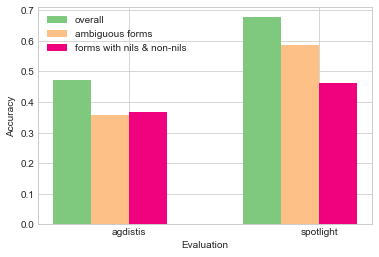

In [11]:
plot_utils.plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [12]:
from scipy.stats import pearsonr, spearmanr

In [13]:
acc_by_form = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

#    dist1=[]
#    dist2=[]
#    for count, forms in forms_by_count.items():
#        for form in forms:
#            dist1.append(count)
#            dist2.append(acc_by_form[system][form])
#    plot_utils.scatter_plot(np.array(dist1), np.array(dist2))

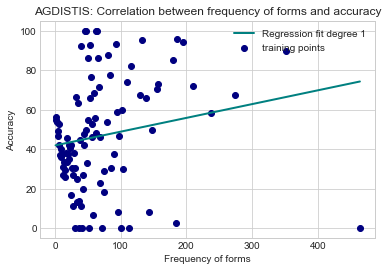

The Spearman correlation between X and Y is: 0.282099018971 . Significance:  0.00426239613232


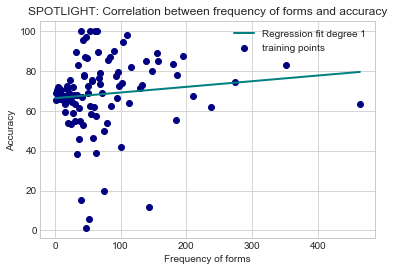

The Spearman correlation between X and Y is: 0.24384007654 . Significance:  0.0139996976231


In [14]:
from collections import OrderedDict
import numpy as np

acc_by_freq={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(forms_by_count.keys()):
        count_forms=forms_by_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='Frequency of forms',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [15]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts,base=len(counts))

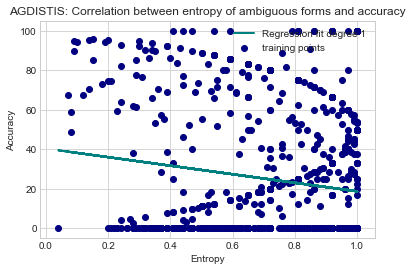

The Spearman correlation between X and Y is: -0.159080179605 . Significance:  2.31881249876e-07


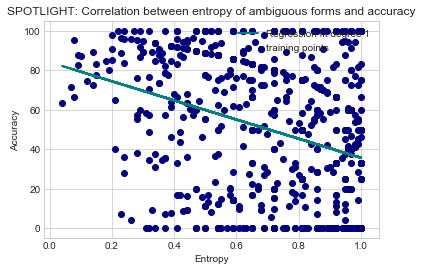

The Spearman correlation between X and Y is: -0.333191685689 . Significance:  1.54521475569e-28


In [16]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(round(form_entropies[f], 2))
        dist2.append(acc_by_form[system][f])

    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [17]:
acc_by_uri = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

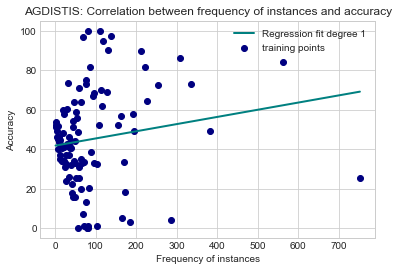

The Spearman correlation between X and Y is: 0.153566197917 . Significance:  0.114284219935


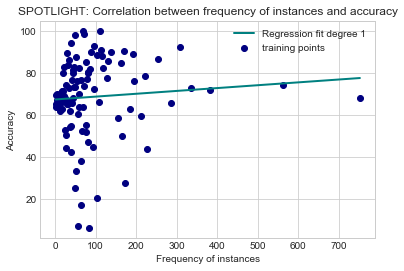

The Spearman correlation between X and Y is: 0.191878719603 . Significance:  0.047710897909


In [18]:
acc_by_freq_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(uris_by_count.keys()):
        count_uris=uris_by_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='Frequency of instances',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [19]:
skip_zeros=True

In [20]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in spot_articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

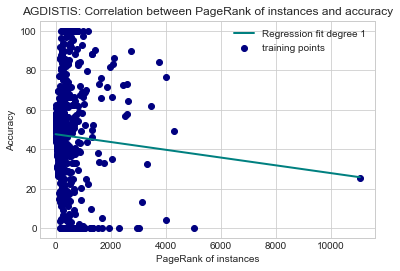

The Spearman correlation between X and Y is: -0.0231898042584 . Significance:  0.566287988911


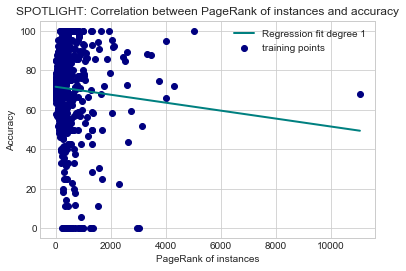

The Spearman correlation between X and Y is: 0.0122592935943 . Significance:  0.761763583849


In [21]:
acc_by_pr_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for pr in sorted(uris_by_pr.keys()):
        if skip_zeros and pr==0: continue

        count_uris=uris_by_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='PageRank of instances',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [22]:
interpretations=defaultdict(set)
for article in spot_articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [23]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [24]:
len(ambiguity)

19280

defaultdict(<class 'float'>, {1: 0.41148115687992987, 2: 0.19045741324921137, 3: 0.11135371179039301, 4: 0.03389830508474576, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


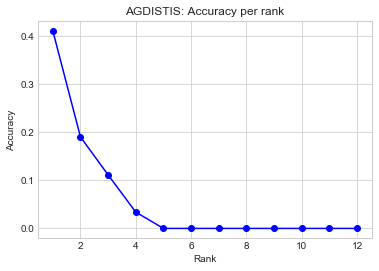

The Spearman correlation between X and Y is: -0.840412818973 . Significance:  0.000619568057643
defaultdict(<class 'float'>, {1: 0.6467134092900964, 2: 0.4195583596214511, 3: 0.34497816593886466, 4: 0.3474576271186441, 5: 0.1875, 6: 0.23076923076923078, 7: 0.0, 8: 0.0, 9: 1.0, 10: 0.0, 11: 0.0, 12: 0.0})


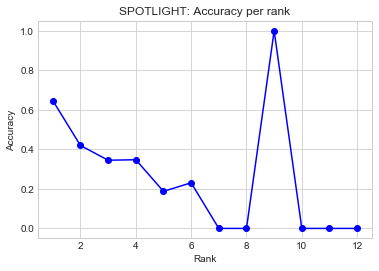

The Spearman correlation between X and Y is: -0.667104681107 . Significance:  0.0177976558063


In [25]:
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank' % system.upper(), save=True)
    


### 8) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


Germany
Britain
England
Spain
Australia
U.S.
Russia
France
Italy
German
defaultdict(<class 'float'>, {1: 0.6392794376098418, 2: 0.024539877300613498, 3: 0.0, 4: 0.05555555555555555, 5: 0.0, 6: 0.0})


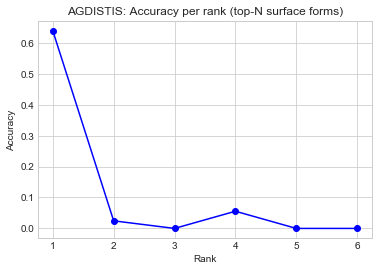

The Spearman correlation between X and Y is: -0.698253251827 . Significance:  0.122839463373
England
Italy
Germany
France
German
Russia
Spain
Australia
U.S.
Britain
defaultdict(<class 'float'>, {1: 0.7069420035149385, 2: 0.8588957055214724, 3: 0.8214285714285714, 4: 0.6666666666666666, 5: 0.0, 6: 1.0})


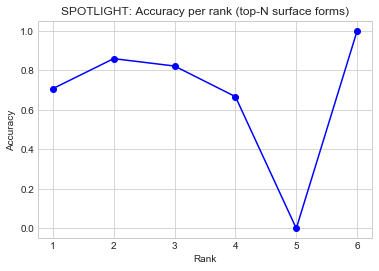

The Spearman correlation between X and Y is: 0.0285714285714 . Significance:  0.95715451895


In [31]:
# Top 10 have form frequency of >135
min_frequency=170
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, 
                                                                total_per_form, 
                                                                min_frequency=min_frequency)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank (top-N surface forms)' % system.upper(), save=True)
    


#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [42]:
form='England'
print(total_per_form[form])
print(correct_per_form[form])

{'England': 142, 'England_national_football_team': 16, 'England_cricket_team': 65, 'England_national_rugby_union_team': 10, 'United_Kingdom': 3, 'Kingdom_of_England': 1}
{'England': 56, 'England_national_football_team': 15, 'England_cricket_team': 65, 'England_national_rugby_union_team': 10, 'United_Kingdom': 0, 'Kingdom_of_England': 1}


In [28]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

{'Germany': 342, 'Germany_Davis_Cup_team': 1, 'Germany_national_football_team': 6, "Germany_men's_national_ice_hockey_team": 1, 'Germany_Fed_Cup_team': 1}
{'Germany': 285, 'Germany_Davis_Cup_team': 0, 'Germany_national_football_team': 6, "Germany_men's_national_ice_hockey_team": 0, 'Germany_Fed_Cup_team': 0}


#### What is going on with China?

In [43]:
for a in spot_articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China Economy_of_China
China Economy_of_China
China Economy_of_China
China_national_football_team China_national_football_team
China_national_football_team China_national_football_team
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
Taiwan China
China China
China China
China China
China --NME--
China --NME--
China --NME--
China --NME--
China China
China China
China China
China China
China China
China China
China China
China China
China Economy_of_China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
Chi

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [45]:
uri_pr

{'Malta': 290.2542,
 'Valletta': 36.2587,
 'Reuters': 98.1778,
 'The_Times': 275.6705,
 'In-Nazzjon': 0.3935,
 'Romania': 1650.548,
 'Malta_Freeport': 1.2092,
 'Singapore': 637.9458,
 'L-Orizzont': 0.7221,
 'Alfred_Sant': 2.2306,
 'Labour_Party_(Malta)': 9.4057,
 'Major_League_Baseball': 501.0357,
 'New_York_City': 2057.7607,
 'American_League': 82.7566,
 'Boston_Red_Sox': 117.9247,
 'Seattle_Mariners': 51.783,
 'Milwaukee_Brewers': 56.1605,
 'Cleveland_Indians': 83.4503,
 'Los_Angeles_Angels_of_Anaheim': 65.7765,
 'Baltimore_Orioles': 69.0907,
 'New_York_Yankees': 143.9285,
 'Oakland_Athletics': 64.6073,
 'Toronto_Blue_Jays': 63.2809,
 'Chicago_White_Sox': 88.388,
 'Detroit_Tigers': 77.2393,
 'Kansas_City_Royals': 53.6356,
 'Minnesota_Twins': 55.6468,
 'Texas_Rangers_(baseball)': 58.2505,
 'National_League': 101.5768,
 'Cincinnati_Reds': 84.3248,
 'Miami_Marlins': 41.7226,
 'Atlanta_Braves': 68.9178,
 'Houston_Astros': 57.5167,
 'Pittsburgh_Pirates': 82.6439,
 'Colorado_Rockies': 41.2

In [52]:
acc_by_form

{'agdistis': defaultdict(int,
             {'NHL': 100.0,
              'NEW YORK': 8.391608391608392,
              'National Hockey League': 40.0,
              'NY RANGERS': 0.0,
              'Toronto': 42.857142857142854,
              'BUFFALO': 0.0,
              'Anaheim': 0.0,
              'Pittsburgh': 25.0,
              'WASHINGTON': 0.0,
              'Montreal': 36.36363636363637,
              'CHICAGO': 0.0,
              'Philadelphia': 40.74074074074074,
              'DALLAS': 27.272727272727273,
              'St Louis': 75.0,
              'COLORADO': 0.0,
              'EDMONTON': 0.0,
              'Ottawa': 60.0,
              'July 28': 0.0,
              '1902': 0.0,
              'philosopher': 63.63636363636363,
              'Sir Karl Raimund Popper': 100.0,
              'philosophers of science': 100.0,
              'Popper': 0.0,
              'Karl Raimund Popper': 100.0,
              'Vienna': 61.904761904761905,
              'Bohemia': 100.0,
    

defaultdict(<class 'int'>, {1: 4446, 2: 717, 3: 48, 4: 21, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 9430, 2: 3955, 3: 841, 4: 185, 5: 117, 6: 27, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.47147401908801695, 2: 0.18128950695322377, 3: 0.057074910820451845, 4: 0.11351351351351352, 5: 0.008547008547008548, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


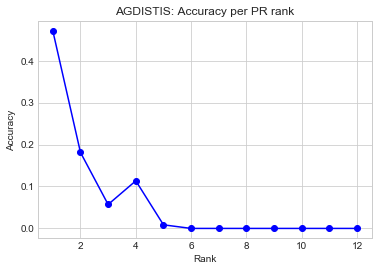

The Spearman correlation between X and Y is: -0.88897165251 . Significance:  0.000109979794947
defaultdict(<class 'int'>, {1: 6399, 2: 1898, 3: 195, 4: 57, 5: 84, 6: 13, 7: 2, 8: 0, 9: 0, 10: 0, 11: 5, 12: 0})
defaultdict(<class 'int'>, {1: 9430, 2: 3955, 3: 841, 4: 185, 5: 117, 6: 27, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.6785790031813361, 2: 0.47989886219974714, 3: 0.2318668252080856, 4: 0.3081081081081081, 5: 0.717948717948718, 6: 0.48148148148148145, 7: 0.2222222222222222, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0})


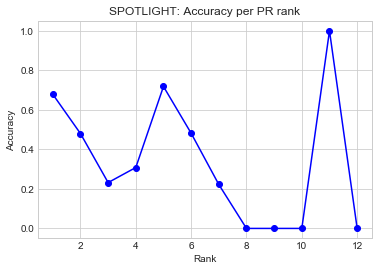

The Spearman correlation between X and Y is: -0.437791730473 . Significance:  0.154625612797


In [60]:
#acc_per_form_meaning={'agdistis': {}, 'spotlight': {}}
for system in systems:
    correct_per_rank_pr=defaultdict(int)
    total_per_rank_pr=defaultdict(int)

    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    for form, meanings in total_per_form.items():
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        form_pageranks=[]
        for uri in meanings.keys():
            form_pageranks.append(tuple((uri_pr[uri], uri)))
        form_pageranks = sorted(form_pageranks, reverse=True)
        for rank in range(1,len(form_pageranks)+1):
            correct_per_rank_pr[rank]+=correct_per_form[form][form_pageranks[rank-1][1]]
            total_per_rank_pr[rank]+=total_per_form[form][form_pageranks[rank-1][1]]

    print(correct_per_rank_pr)
    print(total_per_rank_pr)
    plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr, 
                          title='%s: Accuracy per PR rank' % system.upper(), save=True)


### 8) Notes

* connectivity should reflect popularity -> try pageRank
* this is the hardest part of the EL task
* sometimes nils are most frequent
* NILs - maybe set them aside
* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference